# Imports

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle as pk
import numpy as np
import sklearn.manifold as man
from tensorflow.python.framework import ops

from model import Emoji2Vec, ModelParams
from phrase2vec import Phrase2Vec
from utils import build_kb, get_examples_from_kb, generate_embeddings, get_metrics

/home/ymentha/Documents/Cours/dlab_project/emojivec/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ymentha/Documents/Cours/dlab_project/emojivec/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ymentha/Documents/Cours/dlab_project/emojivec/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16"

# Initializations
This step takes a while to execute, wait for 'DONE'

## Constants and Hyperparameters

In [3]:
word2vec_path = './data/word2vec/GoogleNews-vectors-negative300.bin'
mapping_path = 'emoji_mapping.p'
data_folder = './data/training/'
embeddings_file = 'generated_embeddings.p'

in_dim = 300   # Length of word2vec vectors
out_dim = 300  # Desired dimension of output vectors
pos_ex = 4
neg_ratio = 1
max_epochs = 40
dropout = 0.0

params = ModelParams(in_dim=in_dim, out_dim=out_dim, pos_ex=pos_ex, max_epochs=max_epochs,
                    neg_ratio=neg_ratio, learning_rate=0.001, dropout=dropout, class_threshold=0.5)


#ckpt_path = './results/unicode/k-300_pos-4_rat-1_ep-40_dr-1/model.ckpt'
ckpt_path = './results/unicode/k-300_pos-4_rat-1_ep-80_dr-1/model.ckpt'

e2v_path = "./results/unicode/k-300_pos-4_rat-1_ep-80_dr-1/emoji2vec.bin"
# e2v_path = params.model_folder('unicode') + '/emoji2vec.bin'
# Y.
#ckpt_path = './results/model.ckpt'
# e2v_path = "pre-trained/emoji2vec.bin"

print(e2v_path)

./results/unicode/k-300_pos-4_rat-1_ep-80_dr-1/emoji2vec.bin


## Build Knowledge Base

In [4]:
print('reading training data from: ' + data_folder)
train_kb, ind2phr, ind2emoj = build_kb(data_folder)

pk.dump(ind2emoj, open(mapping_path, 'wb'))

reading training data from: ./data/training/


## Read or Generate Embeddings

In [5]:
embeddings_array = generate_embeddings(ind2phr=ind2phr, kb=train_kb, embeddings_file=embeddings_file,
                                             word2vec_file=word2vec_path)
print('DONE')

loading embeddings...
DONE


## Initialize models and mappings

In [6]:
print('Initializing: reading embedding data from: ' + word2vec_path)
# get the vector for a phrase
phraseVecModel = Phrase2Vec.from_word2vec_paths(params.in_dim, word2vec_path, e2v_path)
print('DONE')

Initializing: reading embedding data from: ./data/word2vec/GoogleNews-vectors-negative300.bin
DONE


In [7]:
ops.reset_default_graph()

# mapping from id to emoji
mapping = pk.load(open(mapping_path, 'rb'))
# mapping from emoji to id
inv_map = {v: k for k, v in mapping.items()}

# tensorflow model
model = Emoji2Vec(params, len(mapping), embeddings_array=embeddings_array)
print('DONE')


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
DONE


In [10]:
# initialize tensorflow session
session = tf.Session()
saver = tf.train.Saver()
saver.restore(session, ckpt_path)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./results/unicode/k-300_pos-4_rat-1_ep-80_dr-1/model.ckpt


# Performance Measures
Check the accuracy, f1 score, auc, and the auc graph

In [12]:
def measures(example_type):
    train_kb, ind2phr, ind2emoj = build_kb(data_folder)
    ex_set = get_examples_from_kb(kb=train_kb, example_type=example_type)

    # evaluate the dev. accuracy using this as the threshold
    thresh = 0.5

    acc = model.accuracy(session=session, dset=ex_set, threshold=thresh)
    f1 = model.f1_score(session=session, dset=ex_set)
    print(str.format('Accuracy at thresh={}: {}', thresh, f1))
    print(str.format('F1 score: {}', f1))
    
    try:
        auc = model.auc(session=session, dset=ex_set)


        print(str.format('AUC score: {}', auc))

        fpr, tpr, thresholds = model.roc_vals(session=session, dset=ex_set)

        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(fpr, tpr)
        ax.set_title("ROC Curve for learned emoji")
        plt.xlabel("false positive rate")
        plt.ylabel("true positive rate")

        #
        #for i , val in enumerate(thresholds):
        #    if i % 10 == 0:
        #        plt.annotate(val, (fpr[i], tpr[i]))

        plt.grid()
        plt.show()
    except:
        print('Can\'t compute AUC or ROC')

In [13]:
print('Train Set')
measures('train')

Train Set
Accuracy at thresh=0.5: 0.9934252003962892
F1 score: 0.9934252003962892
Can't compute AUC or ROC


Dev Set
Accuracy at thresh=0.5: 0.6371191135734072
F1 score: 0.6371191135734072
AUC score: 0.632512


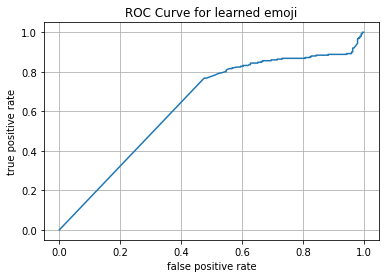

In [14]:
print('Dev Set')
measures('dev')

Test Set
Accuracy at thresh=0.5: 0.6427586206896553
F1 score: 0.6427586206896553
AUC score: 0.6050399999999999


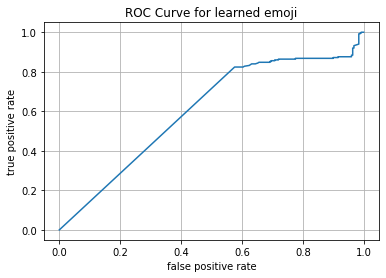

In [15]:
print('Test Set')
measures('test')

In [15]:
# RESET THE GRAPH
ops.reset_default_graph()
model = Emoji2Vec(params, len(mapping), embeddings_array=None, use_embeddings=False)

session = tf.Session()
saver = tf.train.Saver()
saver.restore(session, ckpt_path)

INFO:tensorflow:Restoring parameters from ./results/unicode/k-300_pos-4_rat-1_ep-40_dr-1/model.ckpt


# Top Emoji Query
Set `phr` as a phrase, and get the top `N` emojis correlating to that phrase.

In [16]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

              embeddings_array:  5.2 MiB
                       ind2phr: 144.1 KiB
                      ind2emoj: 72.1 KiB
                       mapping: 72.1 KiB
                       inv_map: 72.1 KiB
                     Emoji2Vec:  1.4 KiB
                   ModelParams:  1.2 KiB
                          _i11:  1.1 KiB
                    Phrase2Vec:  1.0 KiB
                           _i4:  791.0 B


In [44]:
phr = 'popcorn'
N = 5

# get the vector representaiton
vec = phraseVecModel[phr]

# query the tensorflow model
res = list()
for colIx in range(0, len(mapping)):
    predict = session.run(model.prob, feed_dict={
        model.col: np.array([colIx]),
        model.orig_vec: np.array([vec])
    })
    res.append(predict)

# print the top N emoji
for ind in sorted(range(len(res)), key=lambda i: res[i], reverse=True)[:N]:
    print(mapping[ind], res[ind])

👹 [1.]
🐽 [1.]
🚭 [1.]
🍸 [1.]
🍤 [1.]


# Top Phrase Query
Set `em` as an emoji, and get the top `N` phrases correlating to that emoji.

In [34]:
# input
em = '👑'
N = 10

# get the relevant vectors from tensorflow
emoji_vecs = session.run(model.V)
vec = emoji_vecs[inv_map[em]]

# print top N phrases
for word, score in phraseVecModel.from_emoji([vec], top_n=1):
    print(str.format("{}\t{}", word, score))

MemoryError: Unable to allocate 3.35 GiB for an array with shape (3000000, 300) and data type float32

# Analogy Task
Set `base` as a base emoji, `minus` as an emoji to subtract from the base, `plus` as an emoji to add, and get the top `N` correlating phrases and emojis relating to this analogy. 

In [20]:
def print_analogy_result(base, minus, plus):
    emoji_vecs = session.run(model.V)
    total = phraseVecModel[base] - phraseVecModel[minus] + phraseVecModel[plus]
    
    res = list()
    for colIx in range(0, len(mapping)):
        predict = session.run(model.prob, feed_dict={
            model.col: np.array([colIx]),
            model.orig_vec: np.array([total / np.linalg.norm(total)])
        })
        res.append(predict)
        
    ems = sorted(range(len(res)), key=lambda i: res[i], reverse=True)[:5]
    print(str.format('{} - {} + {} = {}', base, minus, plus, [mapping[em] for em in ems]))

In [50]:
print_analogy_result('👑', '🚹', '🚺')
print_analogy_result('💵', '🇺🇸', '🇬🇧')
print_analogy_result('💵', '🇺🇸', '🇪🇺')
print_analogy_result('👦', '👨', '👩')
print_analogy_result('👪', '👦', '👧')
print_analogy_result('🕶', '☀️', '⛈')

👑 - 🚹 + 🚺 = ['👸', '👑', '🏰', '🎎', '🐞']
💵 - 🇺🇸 + 🇬🇧 = ['💵', '💴', '💷', '💶', '💸']
💵 - 🇺🇸 + 🇪🇺 = ['💵', '💴', '💶', '💷', '💸']
👦 - 👨 + 👩 = ['👸', '👪', '👩', '👵', '🐣']
👪 - 👦 + 👧 = ['👪', '👭', '👸', '🚼', '🐣']
🕶 - ☀️ + ⛈ = ['👹', '😿', '👺', '❄️', '🎃']


In [22]:
# input
base = '👑'
# base = '👨'
minus = '🚹'
plus = '🚺'
N = 10

# get the relevant vectors from tensorflow
emoji_vecs = session.run(model.V)
total = emoji_vecs[inv_map[base]] - emoji_vecs[inv_map[minus]] + emoji_vecs[inv_map[plus]]

# print the top N phrases
print(str.format('Top {} matching phrases:', N))
print()
for word, score in phraseVecModel.from_emoji([total], top_n=N):
    print(str.format("{}\t{}", word, score))
    
# query the tensorflow model
res = list()
for colIx in range(0, len(mapping)):
    predict = session.run(model.prob, feed_dict={
        model.col: np.array([colIx]),
        model.orig_vec: np.array([total / np.linalg.norm(total)])
    })
    res.append(predict)

# print the top N emoji
print()
print(str.format('Top {} matching emoji:', N))
print()
for ind in sorted(range(len(res)), key=lambda i: res[i], reverse=True)[:N]:
    print(mapping[ind], res[ind])

Top 10 matching phrases:



MemoryError: Unable to allocate 3.35 GiB for an array with shape (3000000, 300) and data type float32

# Visualize Emoji Vector Space
2-D projection of the Emoji vector space, using t-SNE.

Jupyter won't plot emoji. Use visualize.py to see a clearer picture.

In [23]:
import emoji

In [24]:
print(emoji.emojize("Python is fun :no_good:", use_aliases=True))


Python is fun 🙅


In [11]:
V = session.run(model.V)

In [12]:
V.s

array([[-1.2790043e+00,  1.1838883e+00,  1.6657804e+00, ...,
        -1.3558075e+00,  5.9408259e-01,  1.1796148e+00],
       [-1.1417958e+00, -2.2919593e+00,  1.6928008e+00, ...,
        -1.4287800e+00, -2.2122910e+00,  2.3086898e+00],
       [ 2.2095492e+00,  3.7728876e-01, -3.6251278e+00, ...,
         2.9401176e+00,  1.0668089e+00,  2.5676258e+00],
       ...,
       [ 3.0482791e-02,  4.9572654e-02,  3.7268661e-02, ...,
        -8.1863187e-02,  4.8745252e-02,  2.2940636e-02],
       [-1.6216785e-03, -9.6944980e-02, -5.7095289e-03, ...,
         8.7282561e-02,  4.5039229e-02,  5.8375411e-02],
       [ 1.2683414e-02,  8.7260373e-02, -2.5820255e-02, ...,
         2.3351096e-02,  9.4676800e-02,  8.2393073e-02]], dtype=float32)

/home/ymentha/Documents/Cours/dlab_project/emojivec/env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 127480 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ymentha/Documents/Cours/dlab_project/emojivec/env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 127472 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ymentha/Documents/Cours/dlab_project/emojivec/env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 128084 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ymentha/Documents/Cours/dlab_project/emojivec/env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 127744 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/ymentha/Documents/Cours/dlab_project/emojivec/env/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeW

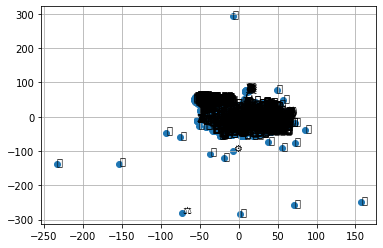

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111)
tsne = man.TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
trans = tsne.fit_transform(V)
x, y = zip(*trans)
plt.scatter(x, y)

for i in range(len(trans)):
    ax.annotate(mapping[i], xy=trans[i], textcoords='data')

plt.grid()
plt.show()